In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix, diags, eye
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot as plt
import pylab

plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (18.0, 12.0)

%matplotlib inline

In [42]:
#df = pd.read_csv("./facebook_combined.txt.gz", compression='infer', sep=" ")
df = pd.read_csv("./twitter_combined.txt.gz", compression='infer', sep=" ", header=None)

print(len(df))
df.head()

2420766


,0,1
0,214328887,34428380
1,17116707,28465635
2,380580781,18996905
3,221036078,153460275
4,107830991,17868918


In [43]:
df.columns = ["0", "1"]

In [44]:
nodes = list(set(df["0"]) | set(df["1"]))
nodes.sort()
nodes[:20]
nodes_to_idx = {n:i for i,n in enumerate(nodes)}

df_o = df
df = pd.DataFrame({"0": df["0"].apply(lambda x: nodes_to_idx[x]), 
                   "1": df["1"].apply(lambda x: nodes_to_idx[x])})
df.head()          

,0,1
0,64848,33444
1,15266,30189
2,76829,19302
3,65515,58679
4,52420,16766


In [45]:
df.describe()

,0,1
count,2.420766e+06,2.420766e+06
mean,3.863062e+04,3.579259e+04
std,2.424377e+04,2.372641e+04
min,0.000000e+00,0.000000e+00
25%,1.635800e+04,1.423600e+04
50%,3.852100e+04,3.366600e+04
75%,6.046100e+04,5.655900e+04
max,8.130500e+04,8.130500e+04


In [6]:
e = len(df)
v = max(np.max(np.unique(df["0"])), np.max(np.unique(df["1"]))) + 1
print(e,v)

2420766 81306


## Passage au Laplacien

In [7]:
facebook2 = csr_matrix((np.ones(e), (df['0'], df['1'])), shape=(v,v))
facebook2 = 1.0 * ((facebook2 + facebook2.T) !=0)

In [8]:
(facebook2 > 1)

<81306x81306 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>

In [9]:
%time deg = np.array(facebook2.sum(axis=0))[0]

print(deg.shape)
print((deg == 0).sum())

Wall time: 17 ms
(81306,)
0


In [10]:
L = diags(np.array(facebook2.sum(axis=0))[0]) - facebook2
L = L.astype(np.float32)
L

<81306x81306 sparse matrix of type '<class 'numpy.float32'>'
	with 2765898 stored elements in Compressed Sparse Row format>

In [11]:
from scipy.sparse.linalg import eigsh

In [12]:
import os.path
import pickle

n_clusters = int(L.shape[0]/40) 
neig = 2 + int(np.log2(n_clusters))

print(n_clusters, neig)

f_vec = "pkl/twitter_eigen_vec_%d.pkl" % neig
f_val = "pkl/twitter_eigen_val_%d.pkl" % neig

if os.path.isfile(f_vec) and os.path.isfile(f_val):
    
    with open(f_vec, "rb") as f:
        eigvec = pickle.load(f)
    with open(f_val, "rb") as f:
        eigval = pickle.load(f)
    
else:
    %time eigval, eigvec = eigsh(L, neig, which='SM', tol=1e-3)
    with open("pkl/twitter_eigen_vec.pkl", "wb") as f:
        pickle.dump(eigvec, f)
    with open("pkl/twitter_eigen_val.pkl", "wb") as f:
        pickle.dump(eigval, f)
# 15 min for 14 et 20...
# 21 min for 12

#%time eigval, eigvec = eigsh(L, neig, which='LM', tol=1e-2, sigma=0)
# very very long! => SystemError: gstrf was called with invalid arguments

eigval

2032 12
Wall time: 5min 45s


FileNotFoundError: [Errno 2] No such file or directory: 'pkl/twitter_eigen_vec.pkl'

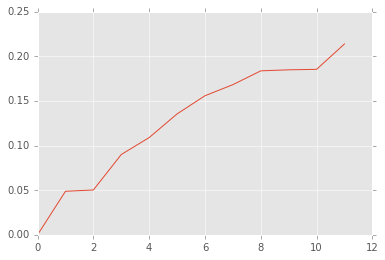

In [13]:
plt.plot(eigval)

In [14]:
e1 = eigvec[:,1]
print((e1>=0).sum(), (e1<0).sum())

1125 80181


(2, 81306)


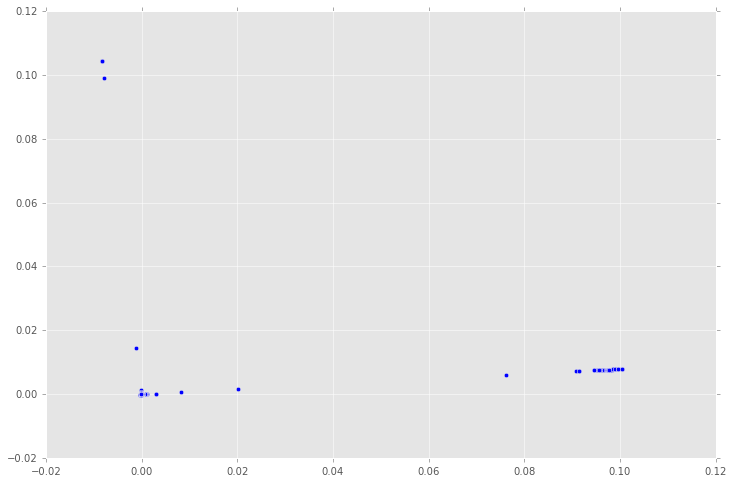

In [15]:
proj = eigvec[:, 1:3].T
print(proj.shape)

pylab.rcParams['figure.figsize'] = (12.0, 8.0)

plt.scatter(proj[0], proj[1])

## kmeans clustering

(81306, 2)
Wall time: 479 ms
4
[[-0.00011692 -0.00829023  0.09831161  0.07625426]
 [-0.00012743  0.10443516  0.00768329  0.0059303 ]]


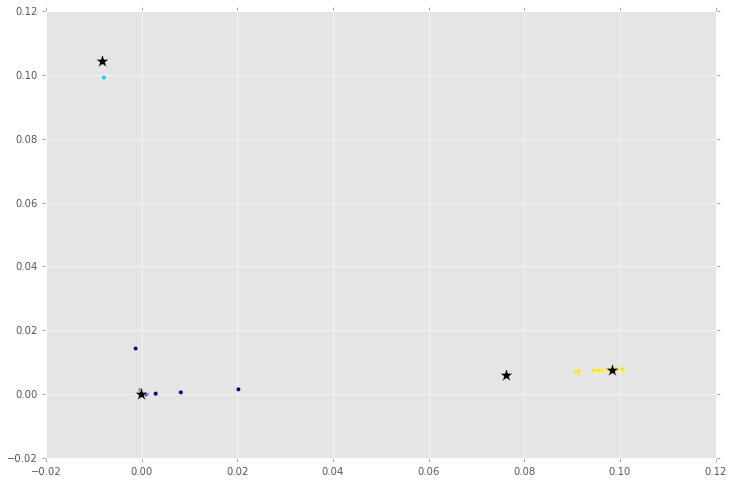

In [16]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

n_clusters = 4

clf = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
#clf = AgglomerativeClustering(n_clusters = n_clusters)
# clf = DBSCAN(eps = 0.005)

print(proj.T.shape)

%time clusters = clf.fit_predict(proj.T)

print(len(np.unique(clusters)))

plt.scatter(proj[0], proj[1], c=clusters)

if "cluster_centers_" in clf.__dict__:
    centers = clf.cluster_centers_.T
    print(centers)
    plt.scatter(centers[0], centers[1], marker='*', s=200, c='black')

### Clustering plus poussé
**Attention:** ici nous normalisons les vecteurs propres.
Cela fait deux différences avec l'algorithme standard de spectral clustering
- normalisation vecteurs propres vs pas normalisation => je retire la normalisation
- 2^k-means sur k vecteurs propres contre k-means sur k vecteurs => je diminue le nombre de clusters

In [17]:
print(eigvec.min(axis=0), eigvec.max(axis=0), eigvec.mean(axis=0))
print(1/(eigvec.max(axis=0) - eigvec.min(axis=0)))

[ 0.00347186 -0.00829527 -0.00029619 -0.09664069 -0.08096015 -0.00122928
 -0.0749449  -0.16102411 -0.020724   -0.15984859 -0.12203973 -0.10767043] [ 0.00355593  0.1005391   0.10449425  0.00050353  0.00088912  0.1726805
  0.00263528  0.00159233  0.08540458  0.04327358  0.00303894  0.01095896] [  3.50707886e-03  -1.64799303e-06  -5.24182724e-07  -9.89251248e-07
  -1.49874427e-06  -1.65201914e-08  -2.47814597e-07  -1.89147940e-07
  -4.07535197e-07  -1.68544801e-07   4.99158318e-07   4.25759822e-07]
[  1.18940889e+04   9.18827343e+00   9.54285622e+00   1.02939730e+01
   1.22175798e+01   5.75010777e+00   1.28898907e+01   6.14943933e+00
   9.42253208e+00   4.92314577e+00   7.99496794e+00   8.42961407e+00]


In [18]:
eigvec_n = (eigvec-eigvec.min(axis=0)) / (eigvec.max(axis=0) - eigvec.min(axis=0))
print(eigvec_n.shape, eigvec.shape)
print(eigvec_n.mean(axis=0))

(81306, 12) (81306, 12)
[ 0.41895232  0.07620408  0.00282145  0.99480647  0.98911887  0.00706841
  0.96602839  0.99020684  0.19526872  0.78695703  0.97570771  0.90762365]


n_clusters = 813
(81306, 11)


C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
C:\Anaconda3\lib\site-packages\skl

Wall time: 2min 56s
813


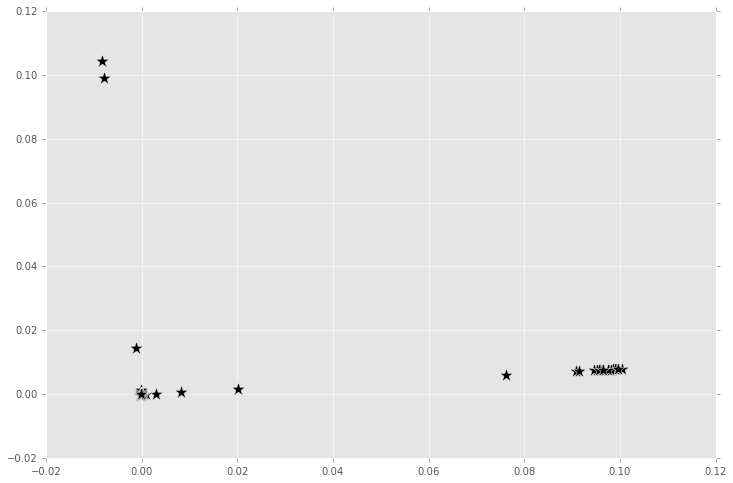

In [34]:
#n_clusters = int(v/40)
n_clusters = int(v/100)
print("n_clusters = %d" % n_clusters)

clf = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10, n_jobs=4)
#clf = AgglomerativeClustering(n_clusters = n_clusters)
#clf = DBSCAN(eps = 0.0005)

#X = eigvec_n[:,1:]
X = eigvec[:,1:]

print(X.shape)
%time clusters = clf.fit_predict(X)
print(len(np.unique(clusters)))

plt.scatter(X[:,0], X[:,1], c=clusters)

if "cluster_centers_" in clf.__dict__:
    centers = clf.cluster_centers_.T
    # print(centers)
    plt.scatter(centers[0], centers[1], marker='*', s=200, c='black')

## display clustered graphs

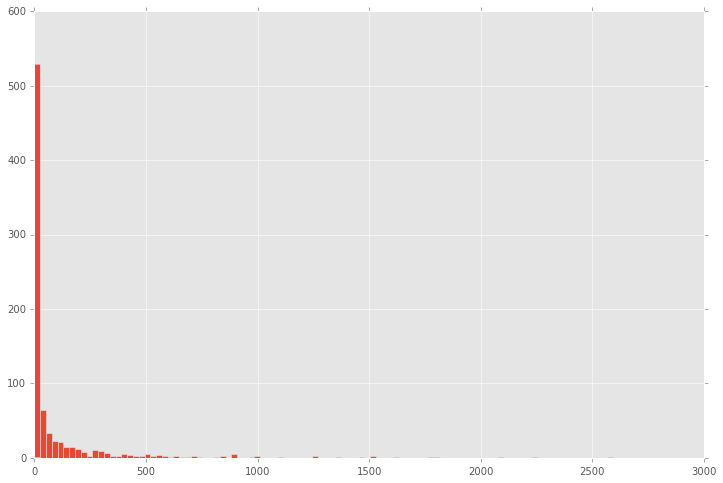

In [35]:
vc = pd.Series(clusters).value_counts()
vc.hist(bins=100)

In [36]:
pd.DataFrame({'cnt': vc}).groupby(["cnt"]).size()

cnt
1       169
2        74
3        54
4        30
5        25
6        15
7        23
8        21
9        19
10       13
11       10
12        6
13        2
14        8
15        5
16        7
17        3
18        3
19        9
20        8
21        4
22        5
23        4
24        3
25        3
26        6
27        8
28        5
29        2
30        4
       ... 
640       1
665       1
694       1
709       1
715       1
739       1
815       1
833       1
853       1
884       1
894       1
897       1
903       1
904       1
974       1
992       1
1008      1
1095      1
1247      1
1270      1
1374      1
1477      1
1506      1
1517      1
1613      1
1770      1
1816      1
2086      1
2247      1
2594      1
dtype: int64

In [46]:
import networkx as nx

%time g = nx.Graph(list(df.to_records(index=False)))
g

Wall time: 30.5 s


Cluster #5 is of size 7
pseudo-degree of cluster is 40


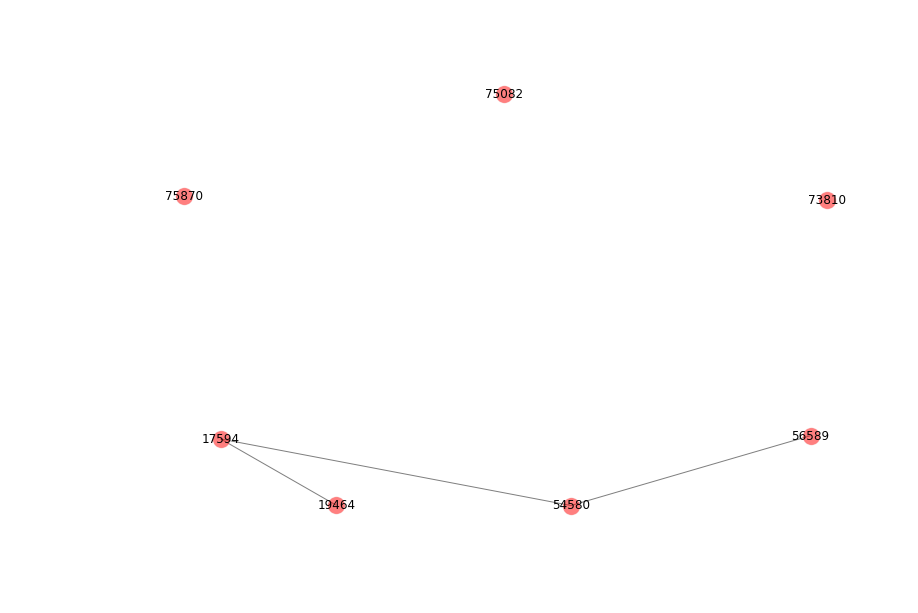

In [47]:
from IPython.html.widgets import interact
import graph_helpers
from imp import reload
reload(graph_helpers)

@interact
def plot(cl = ('5', '6', '7', '8', '10', '20', '30', '27', '215', '42', '1150'), 
         degree=("0", "1", "2"), layout=("spring", "std", "spectral")):
    cl = int(cl)
    print("Cluster #%d is of size %d" % (cl, (clusters == cl).sum()))
    
    print("pseudo-degree of cluster is %d" % graph_helpers.get_deg_sub(facebook2, clusters == cl))
    
    graph_helpers.plot_subgraph_links(facebook2, clusters == cl, int(degree), layout=layout, graph=g)

In [48]:
n = 46401

print((clusters[n]), (clusters == clusters[n]).sum())
print((df["0"] == n).sum())
print((df["1"] == n).sum())
df[(df["1"] == n) | (df["0"] == n)]

522 640
128
3


,0,1
1679589,46401,11249
1702103,6359,46401
2383045,482,46401
2384153,34575,46401
2408159,46401,38556
2408160,46401,28345
2408161,46401,11852
2408162,46401,44979
2408163,46401,70900
2408164,46401,55162


In [49]:
df.head()

,0,1
0,64848,33444
1,15266,30189
2,76829,19302
3,65515,58679
4,52420,16766


Wall time: 1min 9s
count      813.000000
mean       432.249692
std       1250.074620
min          1.000000
25%          9.000000
50%         41.000000
75%        195.000000
max      11619.000000
dtype: float64


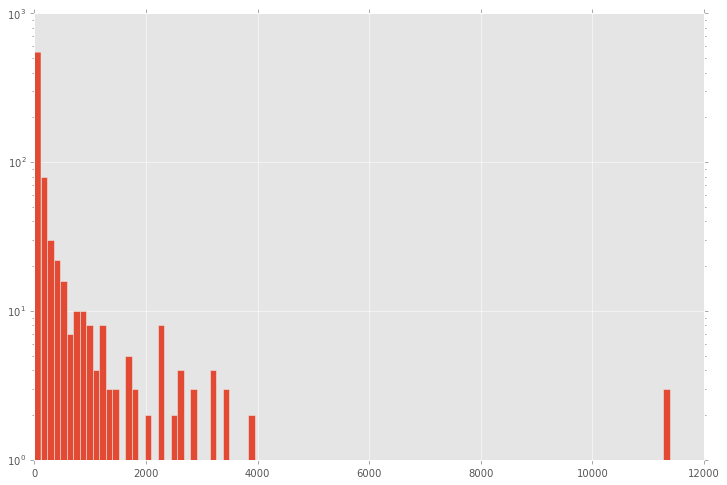

In [50]:
from gmet import group_vertex_degree, group_edge_degree

%time all_degs = [group_vertex_degree(facebook2, clusters == i) for i in range(n_clusters)]

print(pd.Series(all_degs).describe())
_ = plt.hist(all_degs, bins=100)
plt.yscale("log")

### Optimisation à faire
Il faudrait optimiser le calcul des deux "degrés" en le faisant en masse par un big produit matriciel

### Compléments à faire
- implémenter d'autres métriques (cf littérature) comme le RatioCut = sigma cuts / taille et Ncut = sigma cuts / vol
- remettre en non normalisé!
- diminuer le k du k-means

In [51]:
from gmet import group_vertex_degree, group_edge_degree

%time metrics = pd.DataFrame({'sz': [(clusters == cl).sum() for cl in range(n_clusters)], \
                          'vdeg': [group_vertex_degree(facebook2, clusters == i) for i in range(n_clusters)], \
                          'edeg': [group_edge_degree(facebook2, clusters == i) for i in range(n_clusters)]})

metrics["vratio"] = metrics.vdeg / metrics.sz
metrics["eratio"] = metrics.edeg / metrics.sz

metrics.describe()

Wall time: 2min 23s


,edeg,sz,vdeg,vratio,eratio
count,813.000000,813.000000,813.000000,813.000000,813.000000
mean,1480.383764,100.007380,432.249692,8.351019,12.801758
std,5733.860244,259.958532,1250.074620,14.382741,16.379581
min,2.000000,1.000000,1.000000,0.011111,0.430000
25%,13.000000,2.000000,9.000000,2.000000,3.461538
50%,77.000000,8.000000,41.000000,4.454545,7.750000
75%,441.000000,63.000000,195.000000,9.133455,16.333333
max,82971.000000,2594.000000,11619.000000,219.000000,219.500000


In [52]:
metrics[metrics.vratio < 0.5].describe()

,edeg,sz,vdeg,vratio,eratio
count,54.000000,54.000000,54.000000,54.000000,54.000000
mean,60.611111,52.388889,13.074074,0.217480,1.168946
std,86.809794,67.717620,23.015870,0.137044,0.349497
min,3.000000,3.000000,1.000000,0.011111,0.430000
25%,13.000000,10.000000,1.000000,0.102778,1.000000
50%,22.500000,23.500000,3.000000,0.200000,1.058422
75%,60.750000,68.500000,16.250000,0.333333,1.267045
max,468.000000,337.000000,118.000000,0.494898,2.000000


In [53]:
metrics[metrics.vratio < 0.5][metrics.vdeg < 10].describe()

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,edeg,sz,vdeg,vratio,eratio
count,39.000000,39.000000,39.000000,39.000000,39.000000
mean,21.897436,21.435897,2.461538,0.177492,1.154899
std,17.827824,21.314432,2.062780,0.123642,0.359357
min,3.000000,3.000000,1.000000,0.011111,0.430000
25%,10.000000,8.500000,1.000000,0.055728,1.000000
50%,19.000000,16.000000,2.000000,0.166667,1.000000
75%,27.500000,26.000000,3.000000,0.265396,1.181818
max,90.000000,100.000000,8.000000,0.428571,2.000000


In [55]:
metrics[metrics.eratio < 0.5].describe()

,edeg,sz,vdeg,vratio,eratio
count,1.0,1.0,1.0,1.00,1.00
mean,43.0,100.0,5.0,0.05,0.43
std,NaN,NaN,NaN,NaN,NaN
min,43.0,100.0,5.0,0.05,0.43
25%,43.0,100.0,5.0,0.05,0.43
50%,43.0,100.0,5.0,0.05,0.43
75%,43.0,100.0,5.0,0.05,0.43
max,43.0,100.0,5.0,0.05,0.43


0.283148831488


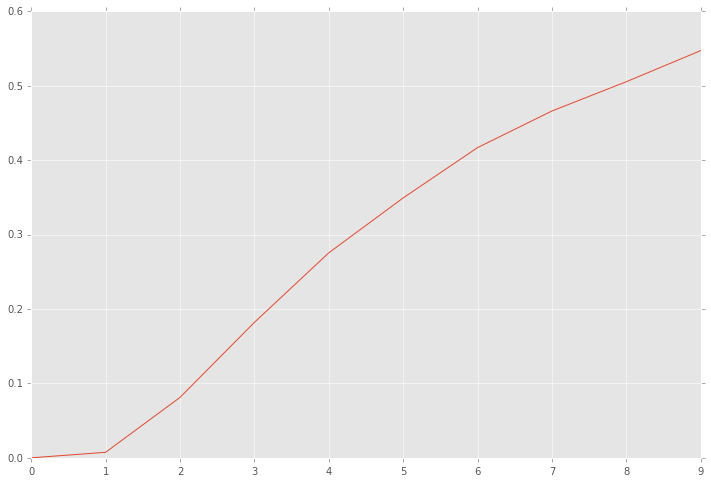

In [56]:
def eratios(df):
    return np.array([len(metrics[metrics.eratio < i])/len(metrics) for i in range(10)])

def perf(df):
    return (eratios(df)/10).sum()

er = eratios(metrics)

print (perf(metrics))

plt.plot(er)

In [58]:
from imp import reload
import gmet
reload(gmet)

metrics["ratio_cut"] = gmet.ratio_cut_list(facebook2, clusters)
metrics["n_cut"] = gmet.n_cut_list(facebook2, clusters)

metrics.describe()

,edeg,sz,vdeg,vratio,eratio,ratio_cut,n_cut
count,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000,813.000000
mean,1480.383764,100.007380,432.249692,8.351019,12.801758,8.351019,0.540728
std,5733.860244,259.958532,1250.074620,14.382741,16.379581,14.382741,0.342520
min,2.000000,1.000000,1.000000,0.011111,0.430000,0.011111,0.001701
25%,13.000000,2.000000,9.000000,2.000000,3.461538,2.000000,0.222011
50%,77.000000,8.000000,41.000000,4.454545,7.750000,4.454545,0.543103
75%,441.000000,63.000000,195.000000,9.133455,16.333333,9.133455,0.871658
max,82971.000000,2594.000000,11619.000000,219.000000,219.500000,219.000000,1.000000


Même avec une centaine de vertex par sous-graphe en moyenne, on a la moitié des sous-graphes à moins de 8 composantes => OK pour diminuer le nombre de clusters!

In [62]:
metrics[metrics.sz >= 4].describe()

,edeg,sz,vdeg,vratio,eratio,ratio_cut,n_cut
count,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000
mean,2319.779070,156.641473,669.943798,6.051767,12.448959,6.051767,0.342412
std,7064.273783,312.655649,1519.250901,7.825818,12.243630,7.825818,0.243184
min,5.000000,4.000000,1.000000,0.011111,0.430000,0.011111,0.001701
25%,78.000000,9.000000,38.000000,1.315038,3.250000,1.315038,0.127672
50%,237.000000,33.500000,115.000000,3.566964,8.413793,3.566964,0.297774
75%,1257.500000,154.250000,499.500000,7.589634,17.901088,7.589634,0.548439
max,82971.000000,2594.000000,11619.000000,65.789474,87.000000,65.789474,0.973970


In [64]:
metrics[(metrics.sz >=4) & (metrics.ratio_cut < 0.2)]

,edeg,sz,vdeg,vratio,eratio,ratio_cut,n_cut
2,90.0,90,1,0.011111,1.000000,0.011111,0.001701
8,33.0,33,1,0.030303,1.000000,0.030303,0.008264
12,57.0,57,1,0.017544,1.000000,0.017544,0.014493
16,20.0,20,1,0.050000,1.000000,0.050000,0.033333
32,27.0,27,1,0.037037,1.000000,0.037037,0.025000
41,71.0,67,11,0.164179,1.059701,0.164179,0.099099
42,8.0,8,1,0.125000,1.000000,0.125000,0.125000
62,19.0,19,1,0.052632,1.000000,0.052632,0.022222
91,43.0,100,5,0.050000,0.430000,0.050000,0.002417
139,20.0,20,1,0.050000,1.000000,0.050000,0.045455


In [59]:
print(metrics.ratio_cut.sum(), metrics.n_cut.sum())

6789.378637312192 439.6117051996319
